In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
import sys
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from astropy import units as u
from galfits import gsutils
from galfits.sed_interp import cosmo_age
from jax.lax import clamp

Could not import regions, which is required for some of the functionalities of this module.


### Step 1: convert photometric table to images

In [24]:
object_flux = Table.read('./132_update_iso_err.cat', format='ascii')
object_bands = ['F435W', 'F606W', 'F814W', 'F090W', 'F105W', 'F125W', 'F140W', 'F150W', 'F200W', 'F277W', 'F356W', 'F444W']
Bands = ['acs_f435w','acs_f606w','wfc3_f814w','nircam_f090w','wfc3_f105w','wfc3_f125w','nircam_f140m','nircam_f150w','nircam_f200w','nircam_f277w','nircam_f356w','nircam_f444w']
z = 0.38 # redshift of the region, consistent with the config file

for loop, band in enumerate(Bands):
    nband = object_bands[loop]
    flux_mjy = object_flux['f_' + nband]
    flux_err = object_flux['e_' + nband]
    outputname = './data/' + band + '.fits'
    gsutils.photometry_to_img(band, flux_mjy, flux_err, z, outputname, unit='mJy')

### Step 2: read config and perform fittings

In [25]:
config_file_path='./photoz.lyric'
workplace = './fit/'    
Myfitter,targ,fs = gsutils.read_config_file(config_file_path,workplace)
    

nircam_f140m is a photometric point
conversion factor is  1
nircam_f140m band image unit to counts rate is  3.5869004e-19
mask image not found, use the zero mask image
nircam_f140m std 0.0
wfc3_f814w is a photometric point
conversion factor is  1
wfc3_f814w band image unit to counts rate is  3.5869004e-19
mask image not found, use the zero mask image
wfc3_f814w std 0.0
nircam_f277w is a photometric point
conversion factor is  1
nircam_f277w band image unit to counts rate is  3.5869004e-19
mask image not found, use the zero mask image
nircam_f277w std 0.0
nircam_f090w is a photometric point
conversion factor is  1
nircam_f090w band image unit to counts rate is  3.5869004e-19
mask image not found, use the zero mask image
nircam_f090w std 0.0
wfc3_f105w is a photometric point
conversion factor is  1
wfc3_f105w band image unit to counts rate is  3.5869004e-19
mask image not found, use the zero mask image
wfc3_f105w std 0.0
wfc3_f125w is a photometric point
conversion factor is  1
wfc3_f125

In [26]:
# add a new parameter to normalize the age
Myfitter.lmParameters.add('normage_total', 0.1, min=0.001, max = 1, brute_step = 0.001,vary = True)
Myfitter.loose_fix_pars()
# define the constrain
def Update_Constraints(pardictlc):
    age = pardictlc['normage_total']*cosmo_age(pardictlc['z_mygal']-0.2)
    pardictlc['total_age_value'] = clamp(0.01,age,13.6)
Myfitter.Set_Update_Constraints(Update_Constraints)
# ES
fr = Myfitter.evolution_strategies(num_generations=10000, popsize=20)
pltwave, Sedcomp, Sedlabel, z = Myfitter.cal_model_image()
print (Myfitter.chisq,z)
             

Generation: 9999, Fitness: 7267.7681: 100%|██████████| 10000/10000 [00:46<00:00, 217.25it/s]


985.89575 0.34873006


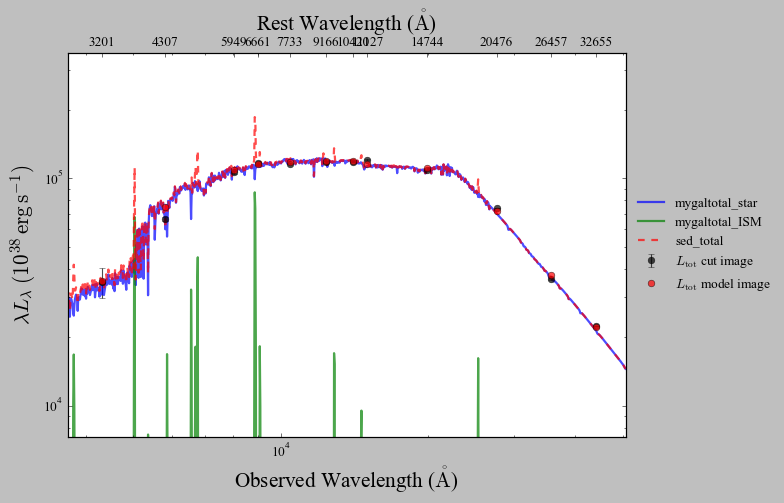

In [27]:
wrange = [0.85,1.15]
pltwave[0] = np.array(pltwave[0])
pltwave[1] = np.array(pltwave[1])
pltwave[3] = np.array(pltwave[3])
waverange = [np.min(pltwave[0]),np.max(pltwave[0])]
if np.max(pltwave[0])/np.min(pltwave[0]) > 10:
    wavegrid = np.logspace(np.log10(wrange[0]*waverange[0]),np.log10(wrange[1]*waverange[1]),1000)
else:
    wavegrid = np.linspace(wrange[0]*waverange[0],wrange[1]*waverange[1],1000)
fig = plt.figure(figsize=(9,6))
ax = plt.gca()
plt.xlim([wrange[0]*waverange[0],wrange[1]*waverange[1]])
plt.errorbar(pltwave[0],pltwave[1]*pltwave[0],yerr=pltwave[2]*pltwave[0],fmt='o',color='k',label=r'$L_\mathrm{tot}$ cut image',alpha=0.7)
plt.errorbar(pltwave[0],pltwave[3]*pltwave[0],fmt='o',color='r',label=r'$L_\mathrm{tot}$ model image',alpha=0.7)
sedtot = np.zeros(len(wavegrid))
for loop in range(len(Sedcomp)):
        plt.plot(wavegrid,wavegrid*Sedcomp[loop],label=Sedlabel[loop],lw=2,alpha=0.7)
        sedtot += Sedcomp[loop]
plt.plot(wavegrid,wavegrid*sedtot,label='sed_total',lw=2,alpha=0.7,linestyle='--')  
plt.xlabel(r'Observed Wavelength ($\mathring{\rm A}$)', fontsize=19)
plt.ylabel(r'$\lambda L_\lambda \; (10^{38} \, \rm erg\,s^{-1})$', fontsize=19)
plt.ylim([0.33*np.min(pltwave[3]*pltwave[0]),3*np.max(pltwave[3]*pltwave[0])])

if np.max(pltwave[0])/np.min(pltwave[0]) > 10:
    plt.xscale('log')
    plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=12, numpoints=1, frameon=False)
# make a upper x-axis labeled by rest wavelength
ax2 = plt.twiny()
ax2.set_xlim([wrange[0]*waverange[0],wrange[1]*waverange[1]])
if np.max(pltwave[0])/np.min(pltwave[0]) > 10:
    ax2.set_xscale('log')
ax2.set_xticks(pltwave[0])
ax2.set_xticklabels(np.array(pltwave[0]/(1.+z),dtype=np.int32))
ax2.set_xlabel(r'Rest Wavelength ($\mathring{\rm A}$)', fontsize=19)
plt.show()